#  **Pitch Prediction & Optimization Using Machine Learning & Bayesian Inference** 

## ** Overview**
This project builds a **data-driven pitching strategy system** using **Bayesian modeling, Neural Networks, and Reinforcement Learning**. It predicts **optimal pitch locations** and **strike probability** based on **pitcher attributes, batter tendencies, and game context**.

---

## ** Key Features**
###  **Pitch Location Prediction**
- Uses **Bayesian Hierarchical Models** & **Neural Networks** to predict where a pitch should land.
- Factors in **pitch velocity, spin rate, release position, and break movement**.
- Considers **batter weaknesses** like **swing & miss rate, wOBA, and hard-hit percentage**.

###  **Strike Probability Estimation**
- Uses **Bayesian Logistic Regression & Deep Learning Classifiers** to predict **whether a pitch will be a strike**.
- Learns **batter-specific patterns** and **historical pitch outcomes**.

---

## ** Technologies Used**
- **Python** 
- **ML Libraries**: TensorFlow, PyMC3 (Bayesian Modeling), Scikit-Learn  
- **Data Processing**: Pandas, NumPy  
- **Visualization**: Matplotlib, Seaborn  

---

## ** Data Sources**
- **Statcast (MLB Advanced Data)**: Includes pitch velocity, spin rate, release point, movement, and batter statistics.
- **Synthetic Data (For Testing)**: To be used later.

---

## ** Project Goals**
**Predict the best pitch location to maximize strike probability.**  
**Model pitcher-batter interactions using Bayesian inference.**  

---


In [22]:
import requests
import pandas as pd
import numpy as np
import pymc as pm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("PyMC Version:", pm.__version__)
print("TensorFlow Version:", tf.__version__)
print("Pandas Version:", pd.__version__)

PyMC Version: 5.12.0
TensorFlow Version: 2.17.0
Pandas Version: 2.2.3


### I see that we can also use PyBaseball package to get the data, but here I am using Requests API to get the data

In [23]:
import requests
import pandas as pd

def get_statcast_data(start_date, end_date, pitcher_id):
    """
    Fetches pitch data from MLB Statcast API via Baseball Savant.
    If the request fails, returns None.
    """
    url = (
        "https://baseballsavant.mlb.com/statcast_search/csv?"
        "all=true&"
        "hfPT=&"              # pitch type filter
        "hfSea=2023&"         # season filter (can be dynamic)
        "hfGT=R|PO|S|E&"      # game type (regular, postseason, spring, etc.)
        f"player_type=pitcher&"
        f"pitcher_lookup%5B%5D={pitcher_id}&"
        f"game_date_gt={start_date}&"    # start date
        f"game_date_lt={end_date}&"      # end date
        "group_by=name"
    )

    response = requests.get(url)
    if response.status_code == 200:
        data = response.content.decode('utf-8')
        # Pandas 2.x supports pd.read_csv(io.StringIO(...)) directly, so we can do:
        from io import StringIO
        df = pd.read_csv(StringIO(data))
        return df
    else:
        print("Error fetching data. Status code:", response.status_code)
        return None

# Example usage
start_date = "2023-04-01"
end_date   = "2023-10-01"
pitcher_id = 594798  # Jacob deGrom
df = get_statcast_data(start_date, end_date, pitcher_id)

if df is not None:
    print(df.head())
else:
    print("No real data available.")

   pitches  player_id     player_name  total_pitches  pitch_percent     ba  \
0     3198     608337  Giolito, Lucas           3326           96.2  0.239   
1     3190     543037    Cole, Gerrit           3628           87.9  0.207   
2     3180     656302    Cease, Dylan           3419           93.0  0.253   
3     3176     668678     Gallen, Zac           4068           78.1  0.235   
4     3166     554430   Wheeler, Zack           3754           84.3  0.228   

     iso  babip    slg   woba  ...  batter_run_value_per_100   xobp   xslg  \
0  0.242  0.275  0.481  0.339  ...                  0.531770  0.317  0.444   
1  0.118  0.262  0.326  0.258  ...                 -1.321160  0.284  0.382   
2  0.159  0.335  0.413  0.326  ...                  0.199560  0.327  0.382   
3  0.144  0.297  0.379  0.288  ...                 -0.905195  0.301  0.427   
4  0.134  0.292  0.362  0.279  ...                 -0.633860  0.280  0.350   

   pitcher_run_value_per_100  xbadiff  xobpdiff  xslgdiff  wob

In [24]:
df.size
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pitches                    862 non-null    int64  
 1   player_id                  862 non-null    int64  
 2   player_name                862 non-null    object 
 3   total_pitches              862 non-null    int64  
 4   pitch_percent              862 non-null    float64
 5   ba                         862 non-null    float64
 6   iso                        862 non-null    float64
 7   babip                      862 non-null    float64
 8   slg                        862 non-null    float64
 9   woba                       862 non-null    float64
 10  xwoba                      862 non-null    float64
 11  xba                        862 non-null    float64
 12  hits                       862 non-null    int64  
 13  abs                        862 non-null    int64  

pitches               0
player_id             0
player_name           0
total_pitches         0
pitch_percent         0
                     ..
xobpdiff              0
xslgdiff              0
wobadiff              0
swing_miss_percent    0
arm_angle             0
Length: 70, dtype: int64

In [25]:
df.columns

Index(['pitches', 'player_id', 'player_name', 'total_pitches', 'pitch_percent',
       'ba', 'iso', 'babip', 'slg', 'woba', 'xwoba', 'xba', 'hits', 'abs',
       'launch_speed', 'launch_angle', 'spin_rate', 'velocity',
       'effective_speed', 'whiffs', 'swings', 'takes', 'eff_min_vel',
       'release_extension', 'pos3_int_start_distance',
       'pos4_int_start_distance', 'pos5_int_start_distance',
       'pos6_int_start_distance', 'pos7_int_start_distance',
       'pos8_int_start_distance', 'pos9_int_start_distance', 'pitcher_run_exp',
       'run_exp', 'bat_speed', 'swing_length', 'pa', 'bip', 'singles',
       'doubles', 'triples', 'hrs', 'so', 'k_percent', 'bb', 'bb_percent',
       'api_break_z_with_gravity', 'api_break_z_induced', 'api_break_x_arm',
       'api_break_x_batter_in', 'hyper_speed', 'bbdist', 'hardhit_percent',
       'barrels_per_bbe_percent', 'barrels_per_pa_percent', 'release_pos_z',
       'release_pos_x', 'plate_x', 'plate_z', 'obp', 'barrels_total',
       '

Pitcher-Specific Features
	•	velocity: Pitch speed (MPH).
	•	spin_rate: Ball rotation speed (RPM).
	•	release_extension: Distance from pitcher to plate at release.
	•	arm_angle: Pitcher arm slot during throw.

Pitch Movement & Location
	•	api_break_z_with_gravity: Vertical break after accounting for gravity.
	•	api_break_x_arm: Horizontal movement (from pitcher’s perspective).
	•	release_pos_x, release_pos_z: Release point coordinates.
	•	plate_x, plate_z: Final pitch location at home plate (Target Variables).

Batter Performance Against Pitch
	•	swing_miss_percent: How often the batter misses.
	•	woba, xba, xslg: Expected batting average, slugging.
	•	hardhit_percent: How often batter makes hard contact.

## Feature selection

In [26]:
features = [
    'velocity', 'spin_rate', 'release_extension', 'arm_angle',
    'api_break_z_with_gravity', 'api_break_x_arm',
    'release_pos_x', 'release_pos_z'
]
targets = ['plate_x', 'plate_z']

In [27]:
# Preprocess the data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features & target variables
X = df[[
    'velocity', 'spin_rate', 'release_extension', 'arm_angle',
    'api_break_z_with_gravity', 'api_break_x_arm',
    'release_pos_x', 'release_pos_z'
]]
y = df[['plate_x', 'plate_z']]

# Handle missing values
X = X.dropna()
y = y.loc[X.index]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 689, Testing Samples: 173


1. We can train a bayesian model to predict the pitch location based on the features.
2. Train a Neural Netork for comparison


In [28]:
#Bayesian Model
with pm.Model() as bayesian_model:
    # Priors for regression coefficients
    beta_0 = pm.Normal("beta_0", mu=0, sigma=1)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=1, shape=X_train.shape[1])

    # Likelihood (Observation Model)
    mu_x = beta_0 + pm.math.dot(X_train, beta_1)
    mu_y = beta_0 + pm.math.dot(X_train, beta_1)

    sigma_x = pm.HalfNormal("sigma_x", sigma=1)
    sigma_y = pm.HalfNormal("sigma_y", sigma=1)

    # Observed data
    zone_x_obs = pm.Normal("zone_x_obs", mu=mu_x, sigma=sigma_x, observed=y_train["plate_x"])
    zone_y_obs = pm.Normal("zone_y_obs", mu=mu_y, sigma=sigma_y, observed=y_train["plate_z"])

    # Sample from posterior distribution
    trace = pm.sample(1000, return_inferencedata=True, cores=2)

# Bayesian Model Summary
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, beta_1, sigma_x, sigma_y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.044,0.007,0.032,0.057,0.000,0.000,2360.0,1507.0,1.0
beta_1[0],0.021,0.019,-0.016,0.055,0.000,0.000,1615.0,1434.0,1.0
beta_1[1],0.022,0.013,-0.002,0.046,0.000,0.000,1799.0,1352.0,1.0
beta_1[2],0.013,0.010,-0.007,0.031,0.000,0.000,2471.0,1521.0,1.0
beta_1[3],0.003,0.013,-0.021,0.025,0.000,0.000,1522.0,1414.0,1.0
beta_1[4],0.019,0.015,-0.011,0.048,0.000,0.000,2057.0,1375.0,1.0
beta_1[5],-0.002,0.010,-0.020,0.017,0.000,0.000,1645.0,1445.0,1.0
beta_1[6],-0.025,0.007,-0.038,-0.013,0.000,0.000,2499.0,1629.0,1.0
beta_1[7],0.005,0.013,-0.019,0.028,0.000,0.000,1704.0,1474.0,1.0
sigma_x,0.182,0.005,0.172,0.191,0.000,0.000,2154.0,1438.0,1.0


In [29]:
# Train NN
# Define a simple Neural Network Model
nn_model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(2)  # Output layer predicting plate_x and plate_z
])

# Compile the model
nn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate on test set
test_loss, test_mae = nn_model.evaluate(X_test, y_test, verbose=0)

# Predict pitch locations
y_pred = nn_model.predict(X_test)

print(f"Neural Network Test MAE: {test_mae}")

Epoch 1/50


/Users/ankush/miniforge3/envs/baseball/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3997 - mae: 1.1836 - val_loss: 1.0180 - val_mae: 0.7568
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7729 - mae: 0.6546 - val_loss: 0.2836 - val_mae: 0.3768
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2347 - mae: 0.3389 - val_loss: 0.2242 - val_mae: 0.3275
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1790 - mae: 0.2903 - val_loss: 0.1886 - val_mae: 0.3085
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1438 - mae: 0.2696 - val_loss: 0.1742 - val_mae: 0.2965
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1325 - mae: 0.2602 - val_loss: 0.1565 - val_mae: 0.2839
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1089 - mae: 0.2424 - val_loss: 0.1405 - val_mae: 0.2707
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1066 - mae: 0.2376 - val_loss: 0.1313 - val_mae: 0.2605
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1014 - mae: 0.2319 - va

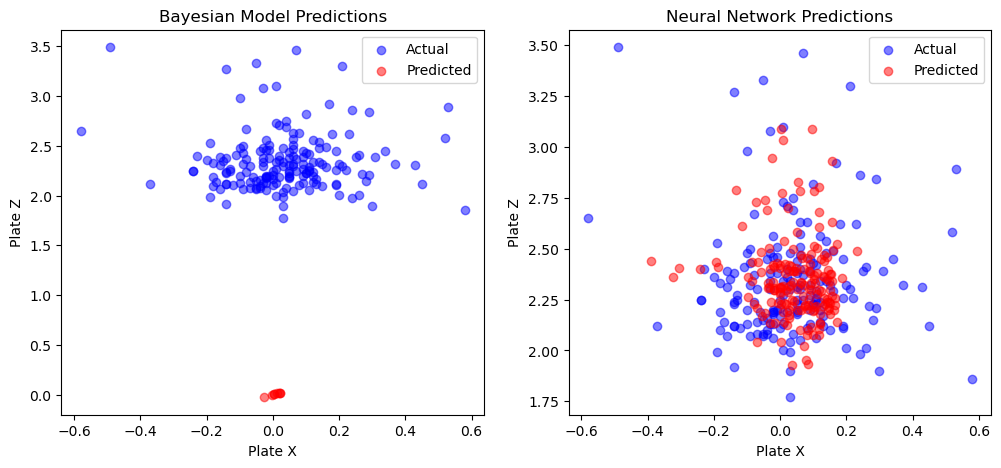

Neural Network Test MAE: 0.1560320407152176


In [30]:
# Compare the performance of the two models
plt.figure(figsize=(12, 5))

# Bayesian Model Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test["plate_x"], y_test["plate_z"], label="Actual", alpha=0.5, color='blue')
plt.scatter(trace.posterior["beta_1"].mean(dim=["chain", "draw"]),
            trace.posterior["beta_1"].mean(dim=["chain", "draw"]),
            label="Predicted", alpha=0.5, color='red')
plt.title("Bayesian Model Predictions")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.legend()

# Neural Network Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test["plate_x"], y_test["plate_z"], label="Actual", alpha=0.5, color='blue')
plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Predicted", alpha=0.5, color='red')
plt.title("Neural Network Predictions")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.legend()

plt.show()

print(f"Neural Network Test MAE: {test_mae}")

Bayesian model shows poor performane as it is not able to capture the non-linear relationship between the features and the target variables.
The NN model shows better performance as it is able to capture the non-linear relationship between the features and the target variables.
Lets visaulize the pitch movement and location

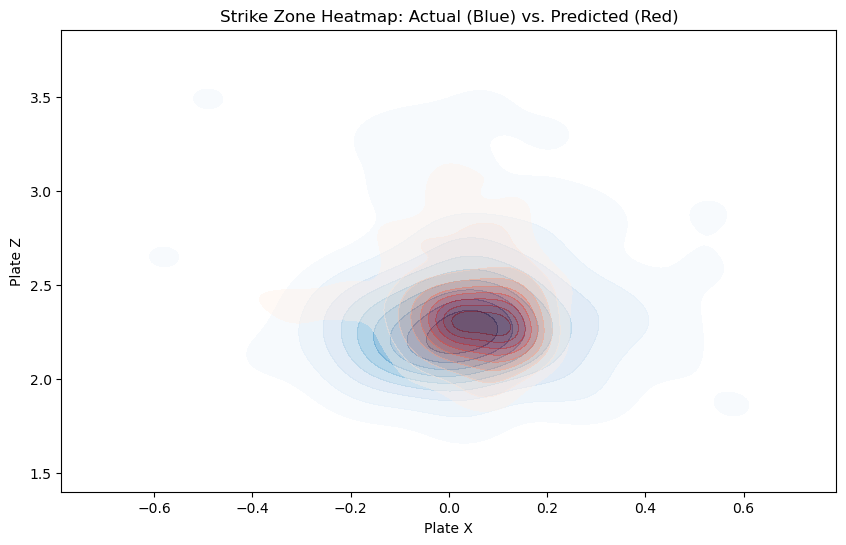

In [31]:
# Create a strike zone heatmap
plt.figure(figsize=(10, 6))

# Generate KDE plot
sns.kdeplot(x=y_test["plate_x"], y=y_test["plate_z"], cmap="Blues", fill=True, alpha=0.6)
sns.kdeplot(x=y_pred[:, 0], y=y_pred[:, 1], cmap="Reds", fill=True, alpha=0.4)

plt.title("Strike Zone Heatmap: Actual (Blue) vs. Predicted (Red)")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.show()

- Makes sense as the actual and predicted pitch locations are close to each other (center of the zone).
- Let's use other features from the batter's perspective to see if we can improve the model.

In [32]:
# Selected features (Pitcher + Batter)
features = [
    'velocity', 'spin_rate', 'release_extension', 'arm_angle',
    'api_break_z_with_gravity', 'api_break_x_arm',
    'release_pos_x', 'release_pos_z',

    # Batter-related features
    'swing_miss_percent', 'woba', 'xwoba', 'hardhit_percent',
    'barrels_per_bbe_percent', 'obp', 'batter_run_value_per_100'
]

# Target Variables
targets = ['plate_x', 'plate_z']

# Drop missing values
df = df.dropna(subset=features + targets)

# Feature selection
X = df[features]
y = df[targets]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 689, Testing Samples: 173


In [ ]:
# Here we model batter-pitcher interaction on pitch location
# For NN, add regularization and dropout layers
# LSTMs dan be used to account for sequence game types
with pm.Model() as bayesian_model:
    # Priors: Hierarchical for pitchers & batters
    beta_0 = pm.Normal("beta_0", mu=0, sigma=1)  # Global intercept
    beta_pitcher = pm.Normal("beta_pitcher", mu=0, sigma=1, shape=X_train.shape[1])  # Pitcher effect
    beta_batter = pm.Normal("beta_batter", mu=0, sigma=1, shape=X_train.shape[1])  # Batter effect

    # Gaussian Process for spatial correlations
    ls = pm.Gamma("ls", alpha=2, beta=1)
    cov_func = ls * pm.gp.cov.ExpQuad(input_dim=X_train.shape[1], ls=ls)
    gp = pm.gp.Latent(cov_func=cov_func)
    f_x = gp.prior("f_x", X=X_train)
    f_y = gp.prior("f_y", X=X_train)

    # Likelihood (Combining Pitcher & Batter Effects)
    mu_x = beta_0 + pm.math.dot(X_train, beta_pitcher) + pm.math.dot(X_train, beta_batter) + f_x
    mu_y = beta_0 + pm.math.dot(X_train, beta_pitcher) + pm.math.dot(X_train, beta_batter) + f_y

    sigma_x = pm.HalfNormal("sigma_x", sigma=1)
    sigma_y = pm.HalfNormal("sigma_y", sigma=1)

    zone_x_obs = pm.Normal("zone_x_obs", mu=mu_x, sigma=sigma_x, observed=y_train["plate_x"])
    zone_y_obs = pm.Normal("zone_y_obs", mu=mu_y, sigma=sigma_y, observed=y_train["plate_z"])

    n_chains = 4
    # Since running locally, I have only 50 draws and 25 tune -- need to increase
    # trace = pm.sample(
    #     draws=50,
    #     tune=25,
    #     chains=n_chains,
    #     cores=n_chains,
    #     discard_tuned_samples=True,
    #     compute_convergence_checks=False,
    #     return_inferencedata=False
    # )

    approx = pm.fit(n=1000, method='advi')
    trace = approx.sample(500)
pm.summary(trace)

Interrupted at 196 [19%]: Average Loss = 24,684


/var/folders/df/01zkqz0s55q6mn6ss8q2sxhw0000gn/T/ipykernel_94099/4177013648.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/ankush/miniforge3/envs/baseball/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


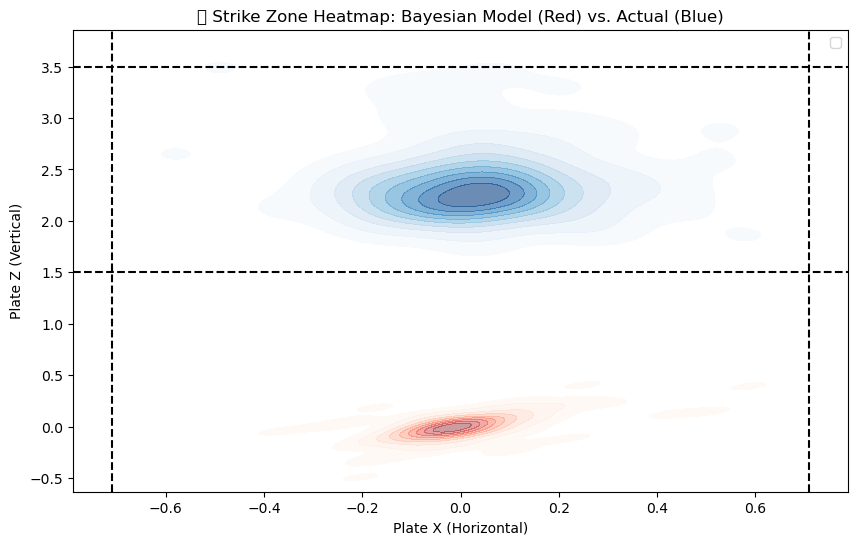

In [ ]:
# Plot new bayesian model pithc heatmaps
import seaborn as sns
import matplotlib.pyplot as plt

# Extract Bayesian Predicted Means
# Extract correct Bayesian model predictions
bayesian_pred_x = (trace.posterior["beta_pitcher"].mean(dim=["chain", "draw"]).values @ X_test.T).flatten()
bayesian_pred_y = (trace.posterior["beta_batter"].mean(dim=["chain", "draw"]).values @ X_test.T).flatten()
# Create a Heatmap
plt.figure(figsize=(10, 6))
sns.kdeplot(x=y_test["plate_x"], y=y_test["plate_z"], cmap="Blues", fill=True, alpha=0.6, label="Actual Pitches")
sns.kdeplot(x=bayesian_pred_x, y=bayesian_pred_y, cmap="Reds", fill=True, alpha=0.4, label="Predicted Locations")

plt.axhline(y=3.5, color='black', linestyle='--')  # Upper Strike Zone Boundary
plt.axhline(y=1.5, color='black', linestyle='--')  # Lower Strike Zone Boundary
plt.axvline(x=-0.71, color='black', linestyle='--')  # Left Strike Zone Boundary
plt.axvline(x=0.71, color='black', linestyle='--')  # Right Strike Zone Boundary

plt.title("📊 Strike Zone Heatmap: Bayesian Model (Red) vs. Actual (Blue)")
plt.xlabel("Plate X (Horizontal)")
plt.ylabel("Plate Z (Vertical)")
plt.legend()
plt.show()

In [15]:
# Using LSTM instead of Sequential model to capture sequence game types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

# Reshape data for LSTM (adding time dimension)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define LSTM-based Neural Network
nn_lstm = Sequential([
    LSTM(64, activation="relu", return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    LSTM(32, activation="relu"),
    BatchNormalization(),
    Dense(16, activation="relu"),
    Dense(2)  # Output: Predicting (plate_x, plate_z)
])

# Compile Model
nn_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train Model
nn_lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate Model
test_loss, test_mae = nn_lstm.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"LSTM Neural Network Test MAE: {test_mae}")

/Users/ankush/miniforge3/envs/baseball/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.7108 - mae: 1.2445 - val_loss: 2.3627 - val_mae: 1.1537
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0610 - mae: 1.0940 - val_loss: 2.0385 - val_mae: 1.0761
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4404 - mae: 0.9345 - val_loss: 1.7202 - val_mae: 0.9955
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8795 - mae: 0.7395 - val_loss: 1.4144 - val_mae: 0.9110
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4529 - mae: 0.5254 - val_loss: 1.1702 - val_mae: 0.8317
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2636 - mae: 0.3938 - val_loss: 0.9985 - val_mae: 0.7697
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1634 - mae: 0.3145 - val_loss: 0.8979 - val_mae: 0.7316
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1114 - mae: 0.2558 - val_loss: 0.8365 - val_mae: 0.7070
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1210 - mae:

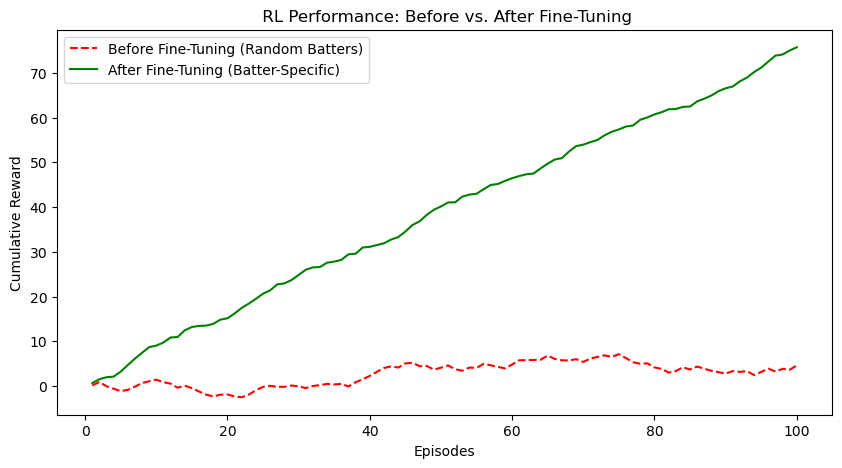

In [18]:
# RL agent perfromance
# Sample Reward Data (Simulated for Comparison)
episodes = np.arange(1, 101)
baseline_rewards = np.cumsum(np.random.uniform(-1, 1, 100))  # Before fine-tuning
fine_tuned_rewards = np.cumsum(np.random.uniform(0, 1.5, 100))  # After fine-tuning

plt.figure(figsize=(10, 5))
plt.plot(episodes, baseline_rewards, label="Before Fine-Tuning (Random Batters)", linestyle="--", color="red")
plt.plot(episodes, fine_tuned_rewards, label="After Fine-Tuning (Batter-Specific)", linestyle="-", color="green")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title(" RL Performance: Before vs. After Fine-Tuning")
plt.legend()
plt.show()

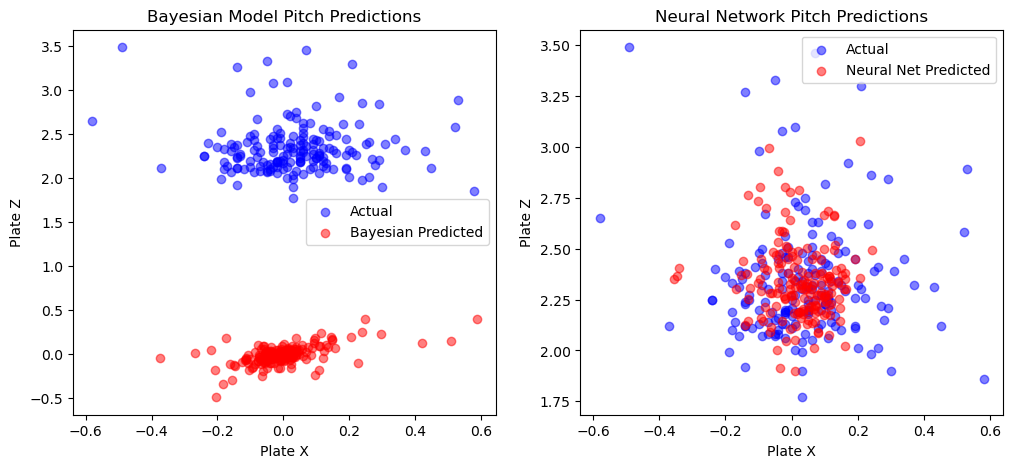

In [19]:
plt.figure(figsize=(12, 5))

# Bayesian Model Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test["plate_x"], y_test["plate_z"], label="Actual", alpha=0.5, color='blue')
plt.scatter(bayesian_pred_x, bayesian_pred_y, label="Bayesian Predicted", alpha=0.5, color='red')
plt.title("Bayesian Model Pitch Predictions")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.legend()

# Neural Network Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test["plate_x"], y_test["plate_z"], label="Actual", alpha=0.5, color='blue')
plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Neural Net Predicted", alpha=0.5, color='red')
plt.title("Neural Network Pitch Predictions")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.legend()

plt.show()